In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import Dataset,DataLoader
from torchvision import utils

import copy

import sys
#sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# Utils to show Tensor Image
unloader = transforms.ToPILImage()
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image, cmap="gray")
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

In [4]:
class colorizationDataset(Dataset):
    def __init__(self, root=None, tf=None):
        self.grey = np.load("./image-colorization/gray_scale.npy") # get your numpy array paths here
        self.grey = torch.from_numpy(self.grey)
        
        self.color = np.load("./image-colorization/ab/ab1.npy")
        self.color = np.concatenate((self.color,np.load("./image-colorization/ab/ab2.npy")))
        self.color = np.concatenate((self.color,np.load("./image-colorization/ab/ab3.npy")))
        self.color = torch.from_numpy(self.color)
        #print(self.images.shape)
        #self.images = self.toPyTensor()
        #print(self.images.shape)

    def __getitem__(self, index):
        return (self.grey[index],self.color[index])
    
    def __len__(self):
        return len(self.grey)
    
    def transformations(self,tf=None):
        if tf is None:
            tf = transforms.ToTensor()
        return tf(self.grey)

# Create Dataset of grey-colored images
dataset = colorizationDataset()



Dataset Length:  25000
Each grayscale image is size:  torch.Size([224, 224])
Each color image is size:  torch.Size([224, 224, 2])
Image data type:  torch.uint8 cpu
Sample image: tensor([[237, 135,  75,  ...,  35,  37,  63],
        [234, 152,  72,  ...,  41,  49,  47],
        [215, 216, 104,  ...,  73,  48,  82],
        ...,
        [ 40,  45,  38,  ...,  11,   8,   8],
        [ 40,  56,  47,  ...,   8,   7,  10],
        [ 42,  60,  79,  ...,  12,  13,  15]], dtype=torch.uint8)
(3, 224, 224)


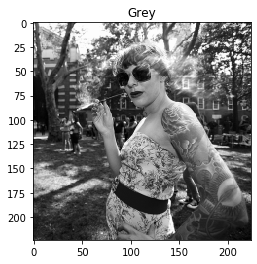

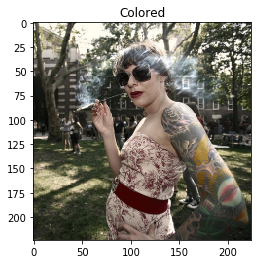

In [24]:
# Dataset Stats
grey, color = dataset[0]
print("Dataset Length: ", len(dataset))
print("Each grayscale image is size: ", grey.shape)
print("Each color image is size: ", color.shape)
print("Image data type: ", grey.dtype , grey.device)
print("Sample image:", grey)
plt.title("Grey")
plt.imshow(grey, cmap="gray")

# Recreating RGB image using the L and AB from the dataset


def toRGB(grey,color):
    # Initializing with zeros ( or any random number)
    img = np.zeros((224, 224, 3))
    img[:, :, 0] = grey
    img[:, :, 1:] = color
    img = img.astype('uint8')
    img_ = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    return img_

# Convert to RGB Space to plot it
plt.figure()
plt.title("Colored")
img_ = toRGB(grey,color)
plt.imshow(img_)
print(img_.transpose(2,1,0).shape)


torch.Size([7, 224, 224])
torch.Size([7, 1, 224, 224])


TypeError: Image data of dtype object cannot be converted to float

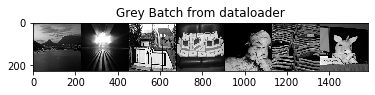

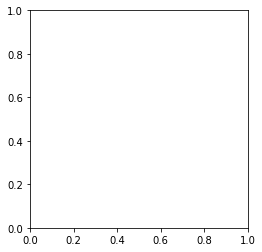

In [50]:
# Helper function to show a batch
def show_images_batch(sample_batched):
    """Show image for a batch of samples."""
    greys_batch, color_batch = \
            sample_batched[0], sample_batched[1]
    
    batch_size = len(greys_batch)
    #print(batch_size)
    im_size = greys_batch.size(2)
    #print(im_size)
    grid_border_size = 2

    print(greys_batch.shape)
    greys_batch = greys_batch.unsqueeze(1)
    print(greys_batch.shape)
    
    grid = utils.make_grid(greys_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title('Grey Batch from dataloader')

    colored = []
    #print(colored.shape)
    
    for i in range(batch_size):
        colored.append(torch.from_numpy(toRGB(greys_batch[i],color_batch[i])))
        plt.figure()
        plt.imshow(colored[i].type) 

    color = torch.stack(colored)
    print(color.view(7,3,224,224).shape)
    #color = color.view(5,3,224,224)
    
    
    plt.figure()
    #color_batch = color_batch.unsqueeze(1)
    grid2 = utils.make_grid(color.view(7,3,224,224))
    plt.imshow(grid2.numpy().transpose(1,2,0))
    #plt.title('Colored Batch from dataloader')

# Create the dataloader
dataloader = DataLoader(dataset, batch_size=7,
                        shuffle=True, num_workers=4)
   
for i_batch, sample_batched in enumerate(dataloader):
    #print(i_batch, sample_batched[0].shape,
     #     sample_batched[1].shape)
    
    # observe 4th batch and stop.
    if i_batch == 2:
        plt.figure()
        show_images_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break
    